# Joseph ASSOUMA, Issa DIA, Thomas MARGNAC et Carla ZEIDAN

## Importation des librairies :

In [145]:
import pandas as pd
import numpy as np
import string
import unidecode
import html
from gensim.models.phrases import Phrases
from gensim.models.ldamodel import LdaModel
from gensim.models.nmf import Nmf
from gensim.models import HdpModel
import pyLDAvis.gensim_models
import gensim.corpora as corpora
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.coherencemodel import CoherenceModel
from nltk import pos_tag
import re
from collections import Counter
import itertools
from itertools import chain
import lda2vec
import matplotlib.pyplot as plt
import numpy as np

## Importation du dataset :

In [23]:
pathToDataset = "News_Category_Dataset_v2.json"
df = pd.read_json(pathToDataset, lines=True, dtype={"headline": str})

Voilà toutes les catégories du jeu de données, ces catégories pourraient nous être utiles pour comparer les résultats des algorithmes de Topic Modelling avec la vérité terrain.

In [24]:
print("Nombre de sujets : ", len(df['category'].unique()))
print("Sujets : ", df['category'].unique())

Nombre de sujets :  41
Sujets :  ['CRIME' 'ENTERTAINMENT' 'WORLD NEWS' 'IMPACT' 'POLITICS' 'WEIRD NEWS'
 'BLACK VOICES' 'WOMEN' 'COMEDY' 'QUEER VOICES' 'SPORTS' 'BUSINESS'
 'TRAVEL' 'MEDIA' 'TECH' 'RELIGION' 'SCIENCE' 'LATINO VOICES' 'EDUCATION'
 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'
 'WELLNESS' 'PARENTING' 'HOME & LIVING' 'STYLE & BEAUTY' 'DIVORCE'
 'WEDDINGS' 'FOOD & DRINK' 'MONEY' 'ENVIRONMENT' 'CULTURE & ARTS']


## Data Pipeline

Concernant notre data pipeline, voici les différentes étapes par lesquelles passent les textes :
* **Qualité des données**: Nous nous assurons que chaque élément du jeu de données est bien un texte et qu'il n'y a pas de donnés manquantes.
* **Suppréssion des éléments non-désirés**: Nous supprimons plusieurs éléments tels que les balises HTML, les erreurs d'encodage UTF-8, ou encore les adresses email.
* **Unification des données**: Nous supprimons la ponctuation, les accents et les textes sont passés en minuscule.
* **Conversion en liste de mots**: Nous convertissons chaque phrase en une liste de mots.
* **Suppression de mots inutiles**: Nous supprimons les mots inutiles tels que 'the', 'of' ou encore 'a'.
* **Creation de n-gram**: Nous re-créons des mots composés tels que "New York City" ou "Donald Trump".
* **Lemmatisation**: Nous regroupons des groupes de mots en un lexique commun.
* **Part of speech / Tagging**: Nous identifions le rôle de chaque mots (verbe, nom, etc ...)

### On s'assure de la qualité des données :

In [25]:
def checkQuality(textList):
    """
    Description
    -----------------
    Check the quality of the dataset.
    
    Param
    -----------------
    textList: List of texts of the dataset.
    
    Return
    -----------------
    Boolean : True if quality if OK.
    """
    # Checking if each element is a string
    assert all([isinstance(text, str) for text in textList])
    assert all([text != np.nan for text in textList])
    return True

### Filtering texts from unwanted characters

In [26]:
def unwanted_char_removing(textList):
    """
    Description
    -----------------
    Remove all unwanted characters in sentences.
    
    Param
    -----------------
    textList: List of texts of the dataset.
    
    Return
    -----------------
    unw_char: List of texts of the dataset without unwanted characters.
    """
    print("Removing unwanted characters ...")
    unw_char = []
    for text in textList:
        new_text = html.unescape(text)
        # Removing links, parenthesis, &, >, invisible space, numbers, ...
        new_text = re.sub(r'https?:\/\/[A-Za-z0-9_.-~\-]*', ' ', new_text, flags=re.MULTILINE)
        new_text = re.sub(r'[(){}\[\]<>]', ' ', new_text, flags=re.MULTILINE)
        new_text = re.sub(r'&amp;#.*;', ' ', new_text, flags=re.MULTILINE)
        new_text = re.sub(r'&gt;', ' ', new_text, flags=re.MULTILINE)
        new_text = re.sub(r'â€™', "'", new_text, flags=re.MULTILINE)
        new_text = re.sub(r'&#x200B;', ' ', new_text, flags=re.MULTILINE)
        new_text = re.sub(r'\d+', ' ', new_text, flags=re.MULTILINE)
        # Removing Twitter username, email address and phone number
        new_text = re.sub(r'@\S+( |\n)', '', new_text, flags=re.MULTILINE)
        new_text = re.sub(r'[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+\.[a-zA-Z0-9-_.]+', '', new_text, flags=re.MULTILINE)
        new_text = re.sub(r"\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4}", '', new_text, flags=re.MULTILINE)
        # Removing multiple spaces
        new_text = re.sub(r'\s+', ' ', new_text, flags=re.MULTILINE)
        unw_char.append(new_text)
    return unw_char

### Unifying our texts:

In [27]:
def punctuation_removing(textList):
    """
    Description
    -----------------
    Remove all punctuation in sentences.
    
    Param
    -----------------
    textList: List of texts of the dataset.
    
    Return
    -----------------
    without_punc: List of texts of the dataset without punctuation.
    """
    print("Removing punctuation ...")
    without_punc = []
    for text in textList:
        tmp = "".join([i for i in text if i not in string.punctuation])
        tmp = tmp.replace("‘","")
        without_punc.append(tmp.replace("’"," "))
    return without_punc

In [28]:
def accent_removing(textList):
    """
    Description
    -----------------
    Remove all accent in sentences.
    
    Param
    -----------------
    textList: List of texts of the dataset.
    
    Return
    -----------------
    without_accent: List of texts of the dataset without accent.
    """
    print("Removing accents ...")
    without_accent = []
    for text in textList:
        without_accent.append(unidecode.unidecode(text))
    return without_accent

In [29]:
def text_to_lowercase(textList):
    """
    Description
    -----------------
    Convert text to lowercase.
    
    Param
    -----------------
    textList: List of texts of the dataset.
    
    Return
    -----------------
    lowercase: List of texts of the dataset in lowercase.
    """
    print("Text to lowercase ...")
    lowercase = []
    for text in textList:
        lowercase.append(text.lower())
    return lowercase

### Converting texts to list of words

In [30]:
def text_to_list(textList):
    """
    Description
    -----------------
    Convert text to list of words.
    
    Param
    -----------------
    textList: List of texts of the dataset.
    
    Return
    -----------------
    word_list: List of texts of the dataset in list of words.
    """
    print("Sentences to list ...")
    word_list = []
    for text in textList:
        word_list.append(text.split())
    return word_list

### Remove useless words

In [117]:
def useless_words_removing(textList):
    """
    Description
    -----------------
    Remove stopwords from texts.
    
    Param
    -----------------
    textList: List of texts of the dataset.
    
    Return
    -----------------
    with_useful_words: List of texts of the dataset without stopwords.
    """
    print("Removing useless words ...")
    stopwords_ = stopwords.words('english')
    with_useful_words = []
    for text in textList:
        with_useful_words.append([word for word in text if not word in stopwords_])
    return with_useful_words

### N-gram creation

In [118]:
def n_gram_creation(textList):
    """
    Description
    -----------------
    Find 2-gram and 3-gram in a sentence.
    
    Param
    -----------------
    textList: List of texts of the dataset.
    
    Return
    -----------------
    with_n_gram: List of texts of the dataset with 2-gram and 3-gram.
    """
    print("Creating bi-grams and tri-grams ...")
    bigram = Phrases(textList, min_count=40, threshold=10)
    trigram = Phrases(bigram[textList], min_count=40, threshold=10)
    with_n_gram = []
    for text in textList:
        with_n_gram.append(trigram[bigram[text]])
    return with_n_gram

### Lemmatize

In [124]:
def lemmatization(textList):
    """
    Description
    -----------------
    Lemmatize words.
    
    Param
    -----------------
    textList: List of texts of the dataset.
    
    Return
    -----------------
    lemmatized: List of texts of the dataset with lemmatized words.
    """
    print("Lemmatize words ...")
    lemmatizer = WordNetLemmatizer()
    lemmatized = []
    for text in textList:
        sentence = []
        for word in text:
            sentence.append(lemmatizer.lemmatize(word))
        lemmatized.append(sentence)
    return lemmatized

### Part-of-speech tagging

In [125]:
def tagging(textList):
    """
    Description
    -----------------
    Identify the role of words in a sentence.
    
    Param
    -----------------
    textList: List of texts of the dataset.
    
    Return
    -----------------
    tagged: List of texts of the dataset with words roles.
    """
    print("Tagging ...")
    tagged = []
    for text in textList:
        tagged.append(pos_tag(text))
    return tagged

In [126]:
def for_lda(textList):
    """
    Description
    -----------------
    Create dictionnary and corpus for LDA
    
    Param
    -----------------
    textList: List of texts of the dataset.
    
    Returns
    -----------------
    tokens: Dictionnary that links words and their ID.
    corpus: mapping of (word_id, word_frequency)
    """
    print("Preparation for LDA ...")
    ldaed = []
    tokens = corpora.Dictionary(textList)
    texts = textList
    corpus = [tokens.doc2bow(text) for text in texts]
    return tokens, corpus

In [127]:
def text_preprocessing(textList):
    """
    Description
    -----------------
    Make whole text preprocessing
    
    Param
    -----------------
    textList: List of texts of the dataset.
    
    Return
    -----------------
    preprocessed: List of texts of the dataset with preprocessing
    """
    to_watch = 73 # 7, 21, 73
    assert checkQuality(textList)
    preprocessed = unwanted_char_removing(textList)
    preprocessed = punctuation_removing(preprocessed)
    preprocessed = accent_removing(preprocessed)
    preprocessed = text_to_lowercase(preprocessed)
    preprocessed = text_to_list(preprocessed)
    preprocessed = useless_words_removing(preprocessed)
    preprocessed = n_gram_creation(preprocessed)
    preprocessed = lemmatization(preprocessed)
    return preprocessed

## Analyse du jeu de données

In [128]:
global_prepro = text_preprocessing(df['headline'].to_list())

Removing unwanted characters ...
Removing punctuation ...
Removing accents ...
Text to lowercase ...
Sentences to list ...
Removing useless words ...
Creating bi-grams and tri-grams ...
Lemmatize words ...


# Nombre d'occurence des 

Text(0.5, 1.0, ' Data Distribution')

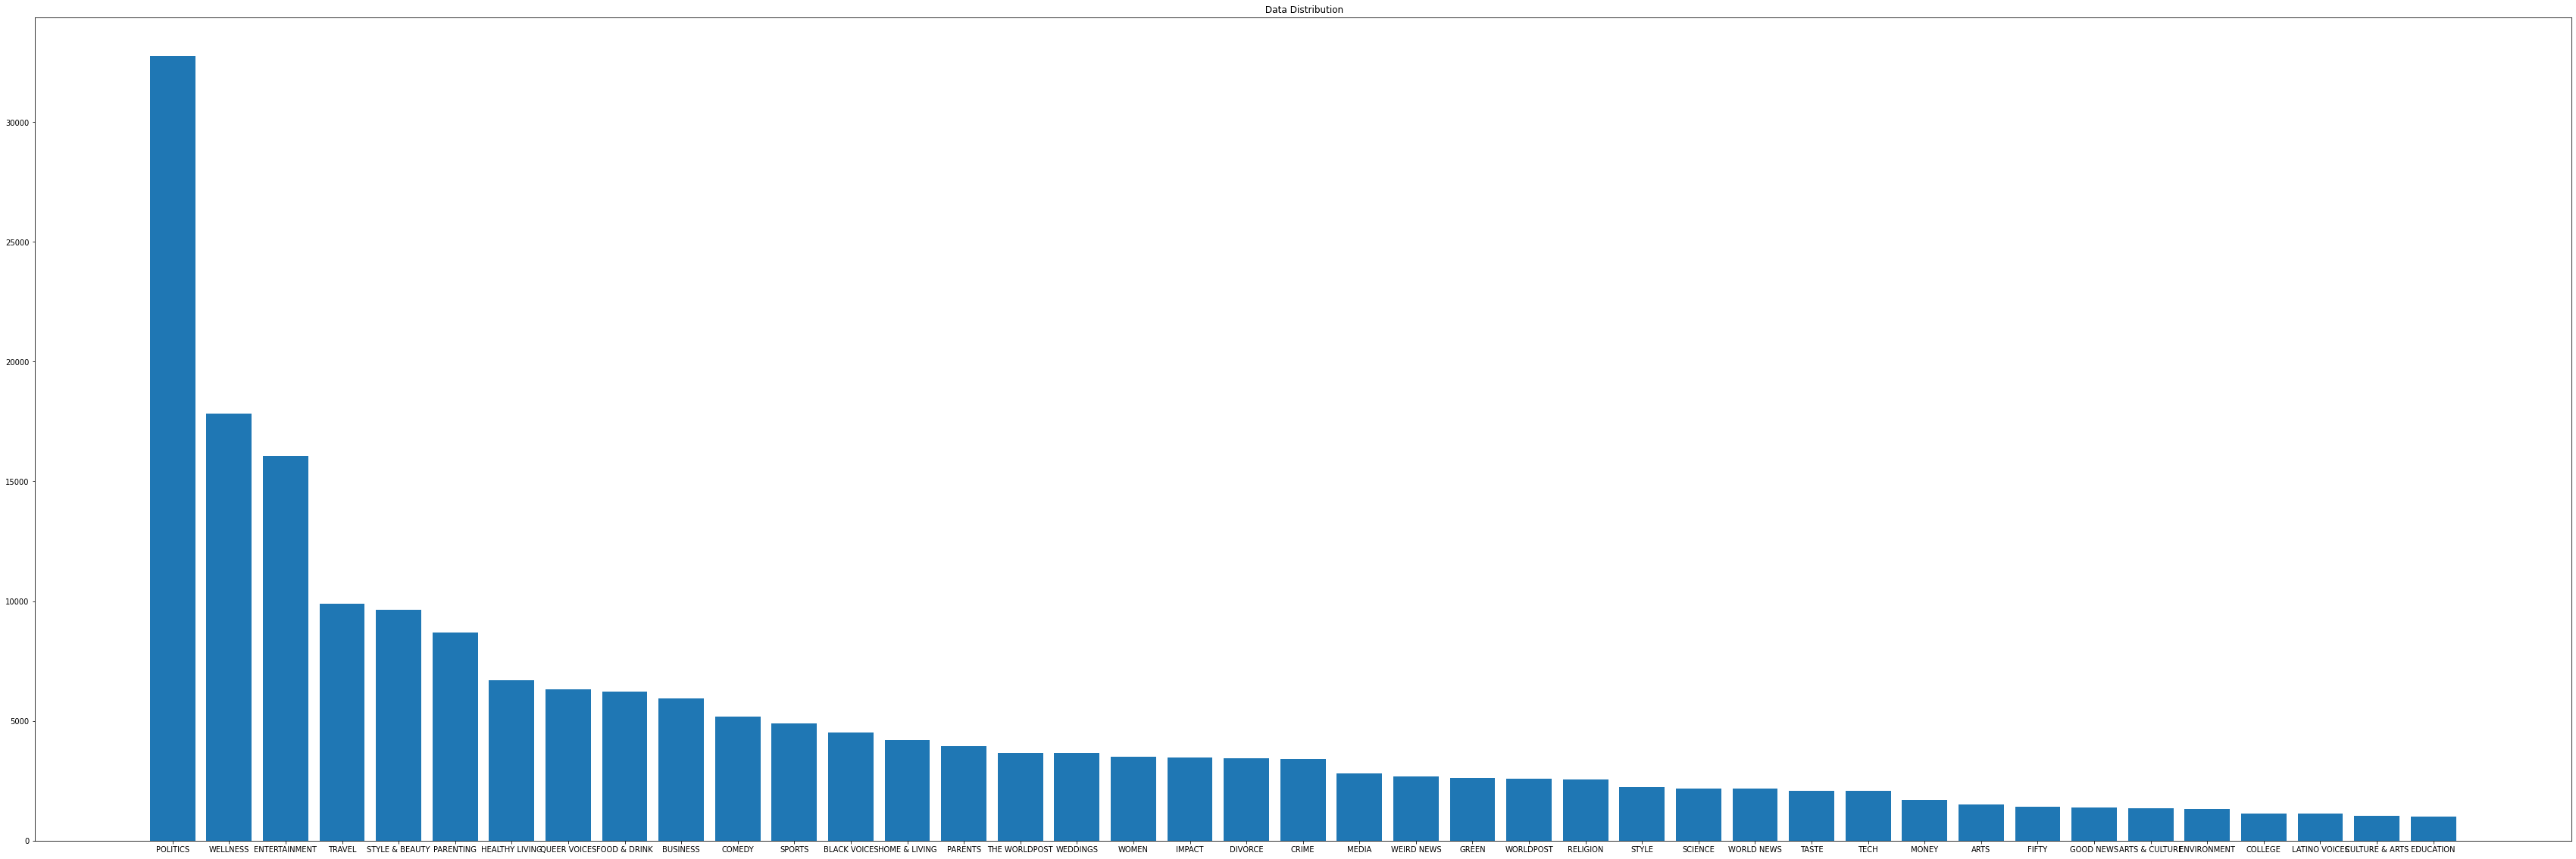

In [150]:
val_count = df.category.value_counts()
plt.figure(figsize=(60,20))
plt.bar(val_count.index, val_count.values)
plt.title(" Data Distribution")

### Nombre de mots par phrase (en moyenne)

#### Avant pre-processing

In [146]:
l = 0
myList = text_to_list(df['headline'].to_list())
for i in myList:
    l += len(i)
print("%.2f" % (l/len(myList)))

#### Après pre-processing

In [147]:
l = 0
for i in global_prepro:
    l += len(i)
print("%.2f" % (l/len(global_prepro)))

Ici, nous remarquons qu'il y a moins de mots par phrases, mais les mots dans ces phrases nous seront plus utiles.

### Types de mots utilisés

#### Avant pre-processing

In [150]:
tagged_before = tagging(myList)
tagged_before_flatten = [item for sublist in tagged_before for item in sublist]
counts_before = Counter(tag for word, tag in tagged_before_flatten)
counts_before.most_common()

Nous remarquons qu'ici il y a énormément de préposition (IN), de déterminants (DT) ou de conjonctions de coordination (CC). Ce sont des éléments qui ne sont pas utiles pour le Topic Modelling, il faut donc les supprimer.

#### Après pre-processing

In [151]:
tagged_after = tagging(global_prepro)
tagged_after_flatten = [item for sublist in tagged_after for item in sublist]
counts_after = Counter(tag for word, tag in tagged_after_flatten)
counts_after.most_common()

Nous voyons qu'il y a beaucoup moins de préposition et de déterminants. Grâce aux stopwords, une majorité a pu être éliminée. Nous remarquons qu'il en reste encore, surement dû à l'absence de certains de ces mots dans la liste de stopwords. Nous remarquons que désormais les types de mots les plus présents sont : les verbes, les noms et les adjectifs.

#### Occurence de chaque mot

In [158]:
def compute_word_occurences(texts):
    """You have to define this function yourself. """
    
    words = itertools.chain.from_iterable(texts)
    
    word_count = pd.Series(words).value_counts()
    word_count = pd.DataFrame({"Word": word_count.index, "Count": word_count.values})

    return word_count

#### Avant pre-processing

In [161]:
compute_word_occurences(myList).head(20)

Nous voyons qu'il y a beacoup de mots inutiles dans le top 20 des mots les plus récurrents tels que 'the', 'to', 'a', 'in' ou encore 'of'. Il faut donc les supprimer pour avoir un meilleur Topic Modelling.

#### Après pre-processing

In [160]:
compute_word_occurences(global_prepro).head(20)

Nous voyons que les mots dans le top 20 des mots les plus utilisés sont tous utiles pour le Topic Modelling. L'entièreté des mots inutiles vus précédemment ont été supprimés.

## Topic Modelling

Nous avons choisi les algorithmes suivant pour modéliser les sujets :
* LDA

Le LDA est utilisé pour classer le texte d'un document dans un sujet particulier. Le LDA construit un modèle de sujet par document et un modèle de mots par sujet. Il est crucial de choisir le bon corpus de données car il suppose que les documents sont produits à partir d'un mélange de sujets. Ces sujets génèrent ensuite des mots sur la base de leur distribution de probabilité. Le LDA ne donne pas le nom des topics, c’est à nous humain de l’interpréter.

Pour :

    - Modèle probabiliste avec des sujets interprétables
    - Il n'est pas nécessaire de savoir à l'avance à quoi ressembleront les sujets
    
    
* HDP

Le HDP est une approche bayésienne non paramétrique du regroupement de données groupées. Il est une variante non-paramétrique de LDA. Elle est dite "non-paramétrique" car le nombre de sujets est déduit des données, et ce paramètre n'est pas fourni. Cela signifie que ce paramètre est appris et peut augmenter

Pour :

    - Le nombre maximum de sujets peut être illimité et appris à partir des données plutôt que spécifié à l'avance.
    

* NMF

Le NMF est une méthode statistique permettant de réduire la dimension des corpus d'entrée. Elle utilise la méthode d'analyse factorielle pour donner comparativement moins de poids aux mots moins cohérents.

Pour :  

    - Le NMF est un modèle linéaire-algébrique qui factorise des vecteurs de haute dimension en une représentation de basse dimension
    - Plus rapide que le LDA
    - Fonctionne mieux avec les textes courts.

# Métriques permettant de mesurer la qualité de nos modèles

Afin de mesurer la qualité de nos modèles, nous avons choisi d'utliser la cohérence comme métrique. La cohérence permet dans notre étude de calculer le lien de pertinence entre les mots dans chancun des topics du clustering.

### Calculons et comparons la cohérence pour nos différents modèles

### LDA

In [129]:
t, c = for_lda(global_prepro)

Preparation for LDA ...


Pour déterminer le nombre optimal de topics à utiliser dans le LDA, nous effectuons une recherche exhaustive afin de trouver le nombre de topics qui maximise la cohérence

In [144]:
coherence = pd.DataFrame(columns=['nb_topics','coherence'])
for nb_topics in range(2,42):
    print(nb_topics)
    lda_model = LdaModel(corpus=c, id2word=t, num_topics=nb_topics, passes=10)
    coherencemodel = CoherenceModel(model=lda_model, texts=global_prepro, dictionary=t, coherence='c_v')
    coherence = coherence.append({'nb_topics':nb_topics,'coherence':coherencemodel.get_coherence()}, ignore_index=True)

2


//anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
//anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:506: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


3
4
5
6


KeyboardInterrupt: 

In [ ]:
coherence[coherence['coherence']==max(coherence['coherence'])]

La meilleure cohérence étant pour le nombre de topics = ..., nous allons l'utiliser pour la suite de notre analyse

In [141]:
lda_model = LdaModel(corpus=c, id2word=t, num_topics=66, passes=10)

In [142]:
coherence_using_lda = CoherenceModel(model=lda_model, texts=global_prepro, dictionary=t, coherence='c_v')
coherence = coherence_using_lda.get_coherence()
print('Coherence Score: ', round(coherence, 3))

//anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
//anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:506: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


Coherence Score:  0.505


Nous pouvons visualiser les performances de notre modèle à l'aide de la librairie pyLDAvis

In [143]:
lda_display = pyLDAvis.gensim_models.prepare(lda_test, c, t, sort_topics=False)
pyLDAvis.display(lda_display)

//anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


# HDP

In [134]:
hdp = HdpModel(c, t)

In [135]:
print(hdp.print_topics())

[(0, '0.004*photo + 0.003*trump + 0.003*new + 0.002*video + 0.002*say + 0.002*woman + 0.002*u + 0.002*make + 0.001*get + 0.001*way'), (1, '0.004*photo + 0.003*trump + 0.002*new + 0.002*say + 0.002*video + 0.002*woman + 0.002*u + 0.002*make + 0.001*get + 0.001*way'), (2, '0.004*photo + 0.003*trump + 0.002*new + 0.002*video + 0.002*say + 0.002*u + 0.002*woman + 0.001*make + 0.001*get + 0.001*way'), (3, '0.004*photo + 0.003*trump + 0.002*new + 0.002*video + 0.002*woman + 0.002*say + 0.002*make + 0.002*u + 0.001*get + 0.001*way'), (4, '0.004*photo + 0.003*trump + 0.002*new + 0.002*video + 0.002*say + 0.002*woman + 0.002*make + 0.002*u + 0.001*get + 0.001*way'), (5, '0.004*photo + 0.003*trump + 0.002*new + 0.002*video + 0.002*say + 0.002*woman + 0.002*make + 0.001*u + 0.001*get + 0.001*way'), (6, '0.004*photo + 0.003*trump + 0.002*new + 0.002*video + 0.002*say + 0.002*u + 0.002*woman + 0.002*make + 0.001*way + 0.001*get'), (7, '0.004*photo + 0.003*trump + 0.002*video + 0.002*new + 0.002*say

In [139]:
coherence_using_hdp = CoherenceModel(model=hdp, texts=global_prepro, dictionary=t, coherence='c_v')
coherence = coherence_using_hdp.get_coherence()
print('Coherence Score: ', round(coherence, 3))

//anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
//anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:506: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


Coherence Score:  0.306


# NMF

In [146]:
coherence = pd.DataFrame(columns=['nb_topics','coherence'])
for nb_topics in range(2,42):
    print(nb_topics)
    nmf = Nmf(c, num_topics=nb_topics,id2word=t, kappa=0.1, chunksize=2000,passes=5, minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42)
    coherencemodel = CoherenceModel(model=nmf, texts=global_prepro,dictionary=t, coherence='c_v')
    coherence = coherence.append({'nb_topics':nb_topics,'coherence':coherencemodel.get_coherence()}, ignore_index=True)

2


//anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
//anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:506: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


3


KeyboardInterrupt: 

In [ ]:
coherence[coherence['coherence']==max(coherence['coherence'])]

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
limit=42; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence)
plt.xticks(range(start, limit, step))
plt.title('NMF')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("Choosing the best number of topics"), loc='best')
ax.grid()
plt.show()

# Conclusion sur nos modèles

Malgré leurs points forts, nos modèles ont quelques limitations.
* Pour le LDA:
    - Il n'y a donc pas de métrique objective pour dire quel hyperparamètre est le meilleur
    - Si la structure du corpus est plus complexe qu'une distribution multinomiale ou si les données d'entraînement ne sont pas suffisantes alors la classification sera très mauvaise
    
* Pour le HDP    


* Pour le NMF:



Nous avons également testé d'autres algorithmes tels que le LSA. mais la faible cohérence que nous avons obtenue (0.16), nous avons préféré l'écarter.
* Pour le LSA:
    - La représentation est dense, donc difficile à indexer sur la base de dimensions individuelles.
    - Il s'agit d'un modèle linéaire, ce qui n'est pas la meilleure solution pour gérer les dépendances non linéaires.
    - Il n’est pas facilement interprétable pour l’humain.
    - Le choix du nombre de sujets est basé sur des heuristiques et nécessite une certaine expertise


Finalement, Le meilleur algorithme que nous avons obtenu est le LDA. Cependant, cet algorithme a quand même une certaine limitation par rapport à nos données car il est plus utilisé pour traiter de longs textes alors qu'ici nous sommes en présence de textes assez cours.